In [1]:
import pandas as pd
import re
import numpy as np
import time
from nltk.stem.porter import PorterStemmer

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense, Flatten,Embedding
from keras.layers import Embedding,LSTM,Bidirectional,GlobalMaxPool1D,Dropout

In [3]:

data = pd.read_json("Sarcasm_Headlines_Dataset.json", lines = True)
data

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
...,...,...,...
26704,https://www.huffingtonpost.com/entry/american-...,american politics in moral free-fall,0
26705,https://www.huffingtonpost.com/entry/americas-...,america's best 20 hikes,0
26706,https://www.huffingtonpost.com/entry/reparatio...,reparations and obama,0
26707,https://www.huffingtonpost.com/entry/israeli-b...,israeli ban targeting boycott supporters raise...,0


In [4]:
data = data.drop(['article_link'], axis=1)
data.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [5]:
data['len'] = data['headline'].apply(lambda x: len(x.split(" ")))
data.head()

,headline,is_sarcastic,len
0,former versace store clerk sues over secret 'b...,0,12
1,the 'roseanne' revival catches up to our thorn...,0,14
2,mom starting to fear son's web series closest ...,1,14
3,"boehner just wants wife to listen, not come up...",1,13
4,j.k. rowling wishes snape happy birthday in th...,0,11


In [6]:
data.isnull().any(axis = 0)

headline        False
is_sarcastic    False
len             False
dtype: bool

In [7]:
data['headline'] = data['headline'].apply(lambda s : re.sub('[^a-zA-Z]', ' ', s))

In [8]:
features = data['headline']
labels = data['is_sarcastic']

In [9]:
ps = PorterStemmer()
features = features.apply(lambda x: x.split())
features = features.apply(lambda x : ' ' .join([ps.stem(word) for word in x]))

### TF-IDF Vectors

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
tv = TfidfVectorizer(max_features = 5000)
features = list(features)
features = tv.fit_transform(features).toarray()

In [11]:
features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = .05, random_state = 0)

## Benchmarking various algorithms

### 1. Linear support vector classifier

In [13]:
lsvc = LinearSVC()

lsvc.fit(features_train, labels_train)

print(lsvc.score(features_train, labels_train))
print(lsvc.score(features_test, labels_test))

0.9093524612777362
0.8375748502994012


### 2. Gaussian Naive Bayes Classifier

In [14]:
gnb = GaussianNB()
gnb.fit(features_train, labels_train)
print(gnb.score(features_train, labels_train))
print(gnb.score(features_test, labels_test))

0.7886335868836952
0.7380239520958084


### 3. Logistic Regression

In [15]:
lr = LogisticRegression()
lr.fit(features_train, labels_train)
print(lr.score(features_train, labels_train))
print(lr.score(features_test, labels_test))

0.8789264178457415
0.8278443113772455


### 4. Random Forest Classifier

In [16]:
rfc = RandomForestClassifier(n_estimators = 10, random_state = 0)
rfc.fit(features_train, labels_train)
print(rfc.score(features_train, labels_train))
print(rfc.score(features_test, labels_test))

0.9882946439128207
0.7971556886227545


### 5. LSTM

Bidirectional Layer:
- A Bidirectional layer processes input sequences in two ways:
    - In the forward direction (left to right)
    - In the backward direction (right to left)
    - This allows the network to capture information from both past and future contexts at each time step, which can be particularly useful for tasks where the full context of the sequence is important.

In this model architecture, the Bidirectional LSTM layer serves a crucial role:
- Position in the model: It's placed immediately after the Embedding layer, which means it processes the sequence of word embeddings.
- Bidirectional processing: The layer processes the input sequence in both forward and backward directions. This allows the model to capture context from both past and future words for each word in the sequence.
- LSTM units: The layer uses 128 LSTM units in each direction. This means it will output 256 features for each time step (128 from forward + 128 from backward).
- return_sequences=True: This parameter is set to True, which means the layer returns the full sequence of outputs for each time step, not just the final output. This is necessary because the next layer (GlobalMaxPool1D) expects a sequence input.
- Output shape: Given the return_sequences=True, the output shape of this layer will be (batch_size, sequence_length, 256), where 256 is the total number of features (128 * 2 directions).
- Context for text classification: In the context of text classification, this Bidirectional LSTM layer allows the model to consider the entire context of each word, looking at both preceding and following words. This can be particularly useful for capturing
- long-range dependencies and understanding the overall sentiment or topic of the text.


The GlobalMaxPool1D layer in this context is taking the output of the Bidirectional LSTM (which has shape (batch_size, sequence_length, 256)) and reducing it to shape (batch_size, 256), where each of the 256 values represents the maximum activation of that feature across the entire sequence. This is a way to distill the information from the sequence into a fixed-size representation that can be passed to the Dense layer for classification.




In [32]:
max_features = 10000
embedding_size = 50

# Create a Sequential model
model = Sequential()

# Add an Embedding layer with pre-trained weights
model.add(Embedding(max_features, embedding_size))

# Add a Bidirectional LSTM layer with 128 units, returning sequences
model.add(Bidirectional(LSTM(128, return_sequences=True)))

# Add a Global Max Pooling layer to reduce sequence dimension
model.add(GlobalMaxPool1D())

# Add a Dense layer with 40 units and ReLU activation
model.add(Dense(40, activation="relu"))

# Add Dropout for regularization
model.add(Dropout(0.5))

# Add another Dense layer with 20 units and ReLU activation
model.add(Dense(20, activation="relu"))

# Add another Dropout layer
model.add(Dropout(0.5))

# Add the output layer with sigmoid activation for binary classification
model.add(Dense(1, activation="sigmoid"))

# Compile the model with binary cross-entropy loss, Adam optimizer, and accuracy metric
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set training parameters
batch_size = 100
epochs = 5

# Train the model
history = model.fit(features_train, labels_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/5
  2/203 ━━━━━━━━━━━━━━━━━━━━ 3:20:12 60s/step - accuracy: 0.4800 - loss: 0.6940

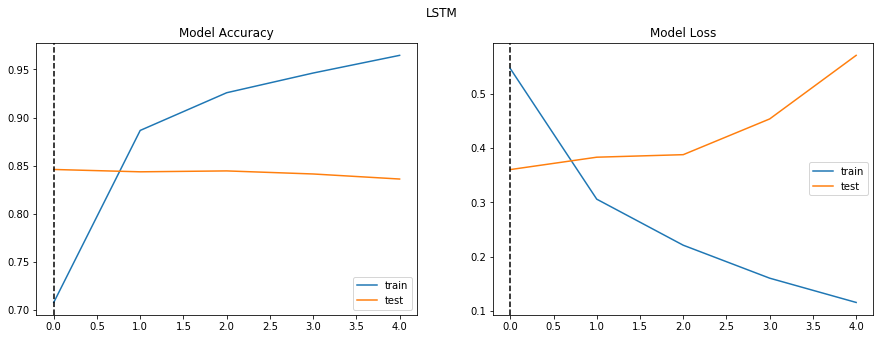

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("LSTM")
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
vline_cut = np.where(history.history['val_accuracy'] == np.max(history.history['val_accuracy']))[0][0]
ax1.axvline(x=vline_cut, color='k', linestyle='--')
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'test'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
vline_cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
ax2.axvline(x=vline_cut, color='k', linestyle='--')
ax2.set_title("Model Loss")
ax2.legend(['train', 'test'])
plt.show()

### 6. Pre-trained embeddings
#### Glove - 50 Dimensional Vectors

In [24]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential

max_features = 10000
maxlen = 25
embedding_size = 50

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(data['headline']))
X = tokenizer.texts_to_sequences(data['headline'])
X = pad_sequences(X, maxlen = maxlen)
y = data['is_sarcastic']

In [25]:
import numpy as np

def load_embeddings(file_path, vocab_size, tokenizer):
    embeddings_dictionary = {}
    embedding_dim = 50  # Assuming 50-dimensional embeddings

    try:
        with open(file_path, encoding="utf8") as glove_file:
            for line in glove_file:
                records = line.split()
                word = records[0]
                vector_dimensions = np.asarray(records[1:], dtype='float32')
                embeddings_dictionary[word] = vector_dimensions
    except FileNotFoundError:
        print(f"Error: File {file_path} not found.")
        return None
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")
        return None

    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, index in tokenizer.word_index.items():
        if index < vocab_size:  # Check if the index is within range
            embedding_vector = embeddings_dictionary.get(word)
            if embedding_vector is not None:
                embedding_matrix[index] = embedding_vector

    return embedding_matrix

# Usage
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
embedding_matrix = load_embeddings('glove.6B.50d.txt', vocab_size, tokenizer)

In [28]:
# Trim the embedding matrix to match max_features
word_index = tokenizer.word_index

num_words = min(max_features, len(word_index) + 1)
embedding_matrix_trimmed = np.zeros((num_words, embedding_size))

for word, i in word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embedding_matrix[i]
    if embedding_vector is not None:
        embedding_matrix_trimmed[i] = embedding_vector


In [30]:
# Create a Sequential model
model = Sequential()

# Add an Embedding layer with pre-trained weights
model.add(Embedding(max_features, embedding_size, weights=[embedding_matrix_trimmed]))

# Add a Bidirectional LSTM layer with 128 units, returning sequences
model.add(Bidirectional(LSTM(128, return_sequences=True)))

# Add a Global Max Pooling layer to reduce sequence dimension
model.add(GlobalMaxPool1D())

# Add a Dense layer with 40 units and ReLU activation
model.add(Dense(40, activation="relu"))

# Add Dropout for regularization
model.add(Dropout(0.5))

# Add another Dense layer with 20 units and ReLU activation
model.add(Dense(20, activation="relu"))

# Add another Dropout layer
model.add(Dropout(0.5))

# Add the output layer with sigmoid activation for binary classification
model.add(Dense(1, activation="sigmoid"))

# Compile the model with binary cross-entropy loss, Adam optimizer, and accuracy metric
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set training parameters
batch_size = 100
epochs = 5

# Train the model
history = model.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.6079 - loss: 0.6423 - val_accuracy: 0.7928 - val_loss: 0.4307
Epoch 2/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8475 - loss: 0.3758 - val_accuracy: 0.8624 - val_loss: 0.3249
Epoch 3/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8993 - loss: 0.2742 - val_accuracy: 0.8714 - val_loss: 0.3183
Epoch 4/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9288 - loss: 0.2032 - val_accuracy: 0.8684 - val_loss: 0.3605
Epoch 5/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9493 - loss: 0.1478 - val_accuracy: 0.8630 - val_loss: 0.3682


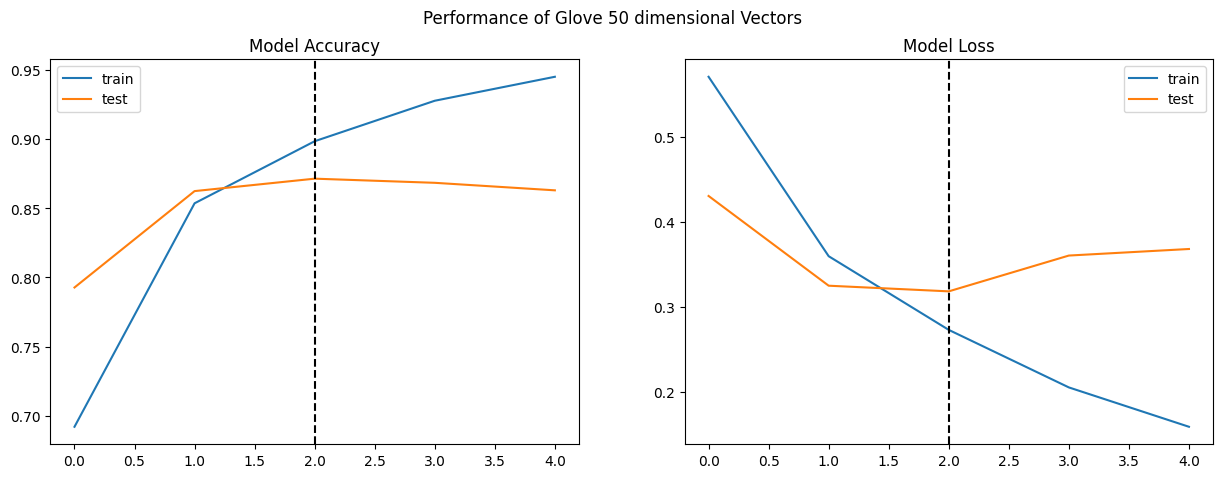

In [31]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Performance of Glove 50 dimensional Vectors")
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
vline_cut = np.where(history.history['val_accuracy'] == np.max(history.history['val_accuracy']))[0][0]
ax1.axvline(x=vline_cut, color='k', linestyle='--')
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'test'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
vline_cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
ax2.axvline(x=vline_cut, color='k', linestyle='--')
ax2.set_title("Model Loss")
ax2.legend(['train', 'test'])
plt.show()